In [1]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # For formatting axis labels as percentages
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score,recall_score
# from sklearn.linear_model import LogisticRegression # Removed for brevity, focusing on LGBM
# from sklearn.ensemble import RandomForestClassifier # Removed for brevity, focusing on LGBM
import lightgbm as lgb # Import LightGBM
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings("ignore")


# 1. Load data

In [2]:
# Load the datasets
data_2016 = pd.read_csv("data_2016_new.csv")
data_2017 = pd.read_csv("data_2017_new.csv")

In [3]:
# Make a copy to avoid modifying the original DataFrame during exploration
df_2016= data_2016.copy()
df_2017= data_2017.copy()


In [4]:
data_2016.head()

,masked_customer_id,jaar,bought_highbrow_wines,Collishop_customer,cat_AP_STDR_PortoONLINE,cat_AP_STDR_WhiskyONLINE,cat_Babyluiers,cat_Ber_Ger_DVPortioneerbaar,cat_Ber_Ger_VersMaaltijdsalades,cat_Bier_Genietbieren,...,cat_nfokay,total_discount,rev_ticket,prod_ticket,n_cogo,cogo_rev,HOUSEHOLDTYPOLOGY,price_sens_colr,SOW_type_colr,SOW_colr
0,339806,2016,0.0,N,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.00,49.870000,6,0,0.0,g_HHnochild_55_plus,-0.1762,SOW20-30,20
1,339807,2016,0.0,N,0.0,0.0,0.0,0.00,0.00,24.74,...,0.0,-9.58,12.841333,2,0,0.0,f_HHnochild_35_54,-0.2743,SOW10-20,15
2,339809,2016,0.0,N,0.0,0.0,0.0,4.99,3.69,0.00,...,0.0,0.00,4.923750,1,0,0.0,j_HHchild_oldest_6_12,-0.1281,SOW40-50,42
3,339812,2016,0.0,N,0.0,0.0,0.0,0.00,0.00,13.08,...,0.0,-7.00,6.221765,1,0,0.0,g_HHnochild_55_plus,-0.3344,SOW20-30,22
4,339815,2016,0.0,N,0.0,0.0,0.0,0.00,0.00,31.92,...,0.0,-2.03,8.070000,4,0,0.0,k_HHchild_oldest_13_17,-0.5497,SOW70-80,71


In [5]:
data_2017.head()

,masked_customer_id,jaar,Collishop_customer,cat_AP_STDR_PortoONLINE,cat_AP_STDR_WhiskyONLINE,cat_Babyluiers,cat_Ber_Ger_DVPortioneerbaar,cat_Ber_Ger_VersMaaltijdsalades,cat_Bier_Genietbieren,cat_Bloemen,...,cat_nfokay,total_discount,rev_ticket,prod_ticket,n_cogo,cogo_rev,HOUSEHOLDTYPOLOGY,price_sens_colr,SOW_type_colr,SOW_colr
0,339793,2017,N,0.0,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.00,2.345000,1.0,0,0.0,c_Single_55_plus,-0.2500,SOW20-30,27
1,339806,2017,N,0.0,0.0,0.0,0.0,0.00,17.62,0.0,...,0.0,-29.37,29.492500,2.0,0,0.0,g_HHnochild_55_plus,-0.0995,SOW10-20,13
2,339807,2017,N,0.0,0.0,0.0,0.0,2.49,2.04,0.0,...,0.0,-0.97,6.350000,2.0,0,0.0,f_HHnochild_35_54,0.0365,SOW20-30,24
3,339809,2017,Y,0.0,0.0,0.0,0.0,3.49,8.99,0.0,...,0.0,0.00,15.297692,2.0,0,0.0,j_HHchild_oldest_6_12,-0.1426,SOW70-80,70
4,339812,2017,N,0.0,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,-3.55,6.065263,1.0,0,0.0,g_HHnochild_55_plus,-0.3327,SOW20-30,22


## 2016 data

In [6]:
# --- Initial Data Check ---
print("--- Data Shape ---")
data_2016.shape


--- Data Shape ---


(200000, 56)

In [7]:
print("\n--- Data Info ---")
data_2016.info()


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 56 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   masked_customer_id               200000 non-null  int64  
 1   jaar                             200000 non-null  int64  
 2   bought_highbrow_wines            199996 non-null  float64
 3   Collishop_customer               199998 non-null  object 
 4   cat_AP_STDR_PortoONLINE          200000 non-null  float64
 5   cat_AP_STDR_WhiskyONLINE         200000 non-null  float64
 6   cat_Babyluiers                   200000 non-null  float64
 7   cat_Ber_Ger_DVPortioneerbaar     200000 non-null  float64
 8   cat_Ber_Ger_VersMaaltijdsalades  200000 non-null  float64
 9   cat_Bier_Genietbieren            200000 non-null  float64
 10  cat_Bloemen                      200000 non-null  float64
 11  cat_Bot_Mar_Boter                200000 non-nu

In [8]:
data_2016.head()

,masked_customer_id,jaar,bought_highbrow_wines,Collishop_customer,cat_AP_STDR_PortoONLINE,cat_AP_STDR_WhiskyONLINE,cat_Babyluiers,cat_Ber_Ger_DVPortioneerbaar,cat_Ber_Ger_VersMaaltijdsalades,cat_Bier_Genietbieren,...,cat_nfokay,total_discount,rev_ticket,prod_ticket,n_cogo,cogo_rev,HOUSEHOLDTYPOLOGY,price_sens_colr,SOW_type_colr,SOW_colr
0,339806,2016,0.0,N,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.00,49.870000,6,0,0.0,g_HHnochild_55_plus,-0.1762,SOW20-30,20
1,339807,2016,0.0,N,0.0,0.0,0.0,0.00,0.00,24.74,...,0.0,-9.58,12.841333,2,0,0.0,f_HHnochild_35_54,-0.2743,SOW10-20,15
2,339809,2016,0.0,N,0.0,0.0,0.0,4.99,3.69,0.00,...,0.0,0.00,4.923750,1,0,0.0,j_HHchild_oldest_6_12,-0.1281,SOW40-50,42
3,339812,2016,0.0,N,0.0,0.0,0.0,0.00,0.00,13.08,...,0.0,-7.00,6.221765,1,0,0.0,g_HHnochild_55_plus,-0.3344,SOW20-30,22
4,339815,2016,0.0,N,0.0,0.0,0.0,0.00,0.00,31.92,...,0.0,-2.03,8.070000,4,0,0.0,k_HHchild_oldest_13_17,-0.5497,SOW70-80,71


# 2. Exploratory Data Analysis (EDA)

In [9]:
print("\n--- Descriptive Statistics (Numerical) ---")
data_2016.describe()


--- Descriptive Statistics (Numerical) ---


,masked_customer_id,jaar,bought_highbrow_wines,cat_AP_STDR_PortoONLINE,cat_AP_STDR_WhiskyONLINE,cat_Babyluiers,cat_Ber_Ger_DVPortioneerbaar,cat_Ber_Ger_VersMaaltijdsalades,cat_Bier_Genietbieren,cat_Bloemen,...,cat_Zomerspeelgoed,cat_bbqfoodevent,cat_nfokay,total_discount,rev_ticket,prod_ticket,n_cogo,cogo_rev,price_sens_colr,SOW_colr
count,2.000000e+05,200000.0,199996.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,2.641546e+06,2016.0,0.049796,0.048809,0.378544,11.993172,0.411080,1.451971,36.496381,2.260722,...,0.528086,3.173120,0.001800,-9.312726,17.546808,2.592925,0.506685,11.436013,-0.295993,38.994955
std,2.252810e+06,0.0,0.217524,3.625113,9.634671,51.765765,3.429648,11.510509,137.049181,11.107610,...,3.091856,8.834216,0.105701,27.178129,30.769143,1.619135,2.963046,82.006099,0.311011,38.395154
min,1.974000e+03,2016.0,0.000000,0.000000,0.000000,-16.960000,-0.010000,-2.820000,-205.630000,0.000000,...,-34.950000,-9.950000,0.000000,-4112.490000,-446.400000,1.000000,0.000000,-31.000000,-1.000000,0.000000
25%,9.040645e+05,2016.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-7.640000,6.882795,1.000000,0.000000,0.000000,-0.411600,11.000000
50%,1.886612e+06,2016.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.490000,11.799815,2.000000,0.000000,0.000000,-0.240700,29.000000
75%,3.519856e+06,2016.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.760000,0.000000,...,0.000000,2.460000,0.000000,0.000000,20.000507,3.000000,0.000000,0.000000,-0.101200,57.000000
max,8.794346e+06,2016.0,1.000000,706.880000,878.840000,1375.800000,575.100000,1023.470000,16594.680000,1005.320000,...,159.950000,943.900000,14.970000,0.060000,2393.250000,23.000000,94.000000,9894.490000,0.900000,3092.000000


In [10]:
print("\n--- Descriptive Statistics (Categorical) ---")
data_2016.describe(include=['object', 'category'])


--- Descriptive Statistics (Categorical) ---


,Collishop_customer,HOUSEHOLDTYPOLOGY,SOW_type_colr
count,199998,200000,200000
unique,2,12,14
top,N,g_HHnochild_55_plus,SOW00-10
freq,175437,60375,43666


### Target Variable Analysis:

In [11]:
# --- Initial Data Preparation (2016) ---
print("--- Initial 2016 Data Prep ---")


--- Initial 2016 Data Prep ---


In [12]:
# Handle the missing target value in 2016
df_2016 = data_2016.dropna(subset=['bought_highbrow_wines']).copy() # Use .copy()

In [13]:
print("\n--- Target Variable Value Counts (Before Handling Missing) ---")
df_2016['bought_highbrow_wines'].value_counts(dropna=False)


--- Target Variable Value Counts (Before Handling Missing) ---


bought_highbrow_wines
0.0    190037
1.0      9959
Name: count, dtype: int64

In [14]:
# Convert target to integer
df_2016['bought_highbrow_wines'] = df_2016['bought_highbrow_wines'].astype(int)

In [230]:
# SIMPLE Visualize Target Variable
# sns.countplot(x='bought_highbrow_wines', data=df_2016, )
# plt.title('Distribution of Target Variable (bought_highbrow_wines)')
# plt.show()

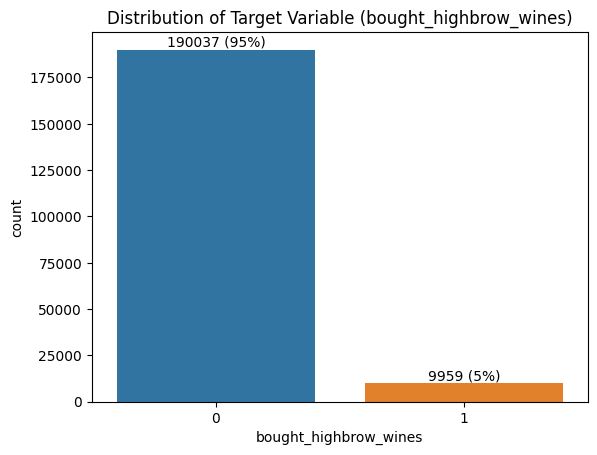

In [233]:
# COMPLEX Visualization of Target Variable with LABELS and PERCENTAGES for Imbalanced class
ax = sns.countplot(x='bought_highbrow_wines', data=df_2016,
                   order=df_2016['bought_highbrow_wines'].value_counts(ascending=False).index);

abs_values = df_2016['bought_highbrow_wines'].value_counts(ascending=False).values
rel_values = df_2016['bought_highbrow_wines'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

plt.title('Distribution of Target Variable (bought_highbrow_wines)')
plt.show()

In [16]:
# Separate target variable
y = df_2016['bought_highbrow_wines']

In [17]:
y

0         0
1         0
2         0
3         0
4         0
         ..
199995    1
199996    1
199997    1
199998    1
199999    1
Name: bought_highbrow_wines, Length: 199996, dtype: int64

In [18]:
# Keep original IDs for later use
customer_ids_2016 = df_2016['masked_customer_id']
customer_ids_2017 = df_2017['masked_customer_id']
print(f"2016 data shape after handling missing target: {df_2016.shape}")

2016 data shape after handling missing target: (199996, 56)


In [19]:
df_2016.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199996 entries, 0 to 199999
Data columns (total 56 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   masked_customer_id               199996 non-null  int64  
 1   jaar                             199996 non-null  int64  
 2   bought_highbrow_wines            199996 non-null  int64  
 3   Collishop_customer               199994 non-null  object 
 4   cat_AP_STDR_PortoONLINE          199996 non-null  float64
 5   cat_AP_STDR_WhiskyONLINE         199996 non-null  float64
 6   cat_Babyluiers                   199996 non-null  float64
 7   cat_Ber_Ger_DVPortioneerbaar     199996 non-null  float64
 8   cat_Ber_Ger_VersMaaltijdsalades  199996 non-null  float64
 9   cat_Bier_Genietbieren            199996 non-null  float64
 10  cat_Bloemen                      199996 non-null  float64
 11  cat_Bot_Mar_Boter                199996 non-null  float64
 12  cat_Bro

In [20]:
# --- Define Column Sets ---
# Define based on original columns BEFORE dropping target or IDs
numerical_cols_orig = df_2016.select_dtypes(include=np.number).columns.tolist()
categorical_cols_orig = df_2016.select_dtypes(include='object').columns.tolist()
cat_spending_cols = [col for col in df_2016.columns if col.startswith('cat_')]

In [21]:
# Exclude target, identifiers, constants
numerical_cols = [col for col in numerical_cols_orig if col not in ['masked_customer_id', 'jaar', 'bought_highbrow_wines']]
categorical_cols = [col for col in categorical_cols_orig if col not in ['masked_customer_id', 'jaar']]

In [22]:
# Separate categorical cols for OHE vs binary mapping
ohe_cols = ['HOUSEHOLDTYPOLOGY', 'SOW_type_colr']
binary_col = ['Collishop_customer']

In [62]:
df_2016['Collishop_customer'].value_counts(dropna=False)

Collishop_customer
N      175433
Y       24561
NaN         2
Name: count, dtype: int64

In [23]:
# ============================================================
# --- Preprocessing 2016 Data (Fit & Transform) ---
# ============================================================

In [41]:
print("\n--- Processing 2016 Data (Fit & Transform) ---")
df_processed_2016 = df_2016.copy()


--- Processing 2016 Data (Fit & Transform) ---


In [43]:
# --- 1. Handle Placeholders (2016) ---
print("Step 1: Handling placeholders (2016)...")
# Replace '!' in categorical columns
df_processed_2016['HOUSEHOLDTYPOLOGY'] = df_processed_2016['HOUSEHOLDTYPOLOGY'].replace('!', 'Unknown')
df_processed_2016['SOW_type_colr'] = df_processed_2016['SOW_type_colr'].replace('!', 'Unknown')

Step 1: Handling placeholders (2016)...


In [44]:
# --- 2. Imputation (Fit & Transform 2016) ---
print("Step 2: Imputing missing values (Fit & Transform 2016)...")
# Numerical Imputer
num_imputer = SimpleImputer(strategy='median')
df_processed_2016[numerical_cols] = num_imputer.fit_transform(df_processed_2016[numerical_cols])
# Categorical Imputer (for OHE + binary cols)
cat_imputer = SimpleImputer(strategy='most_frequent')
df_processed_2016[ohe_cols + binary_col] = cat_imputer.fit_transform(df_processed_2016[ohe_cols + binary_col])

Step 2: Imputing missing values (Fit & Transform 2016)...


----- Few additional check ------- 

In [45]:
print("\n--- Additional Preprocessing Checks (on Imputed 2016 Data) ---")



--- Additional Preprocessing Checks (on Imputed 2016 Data) ---



1. Correlation Analysis (Numerical Features)


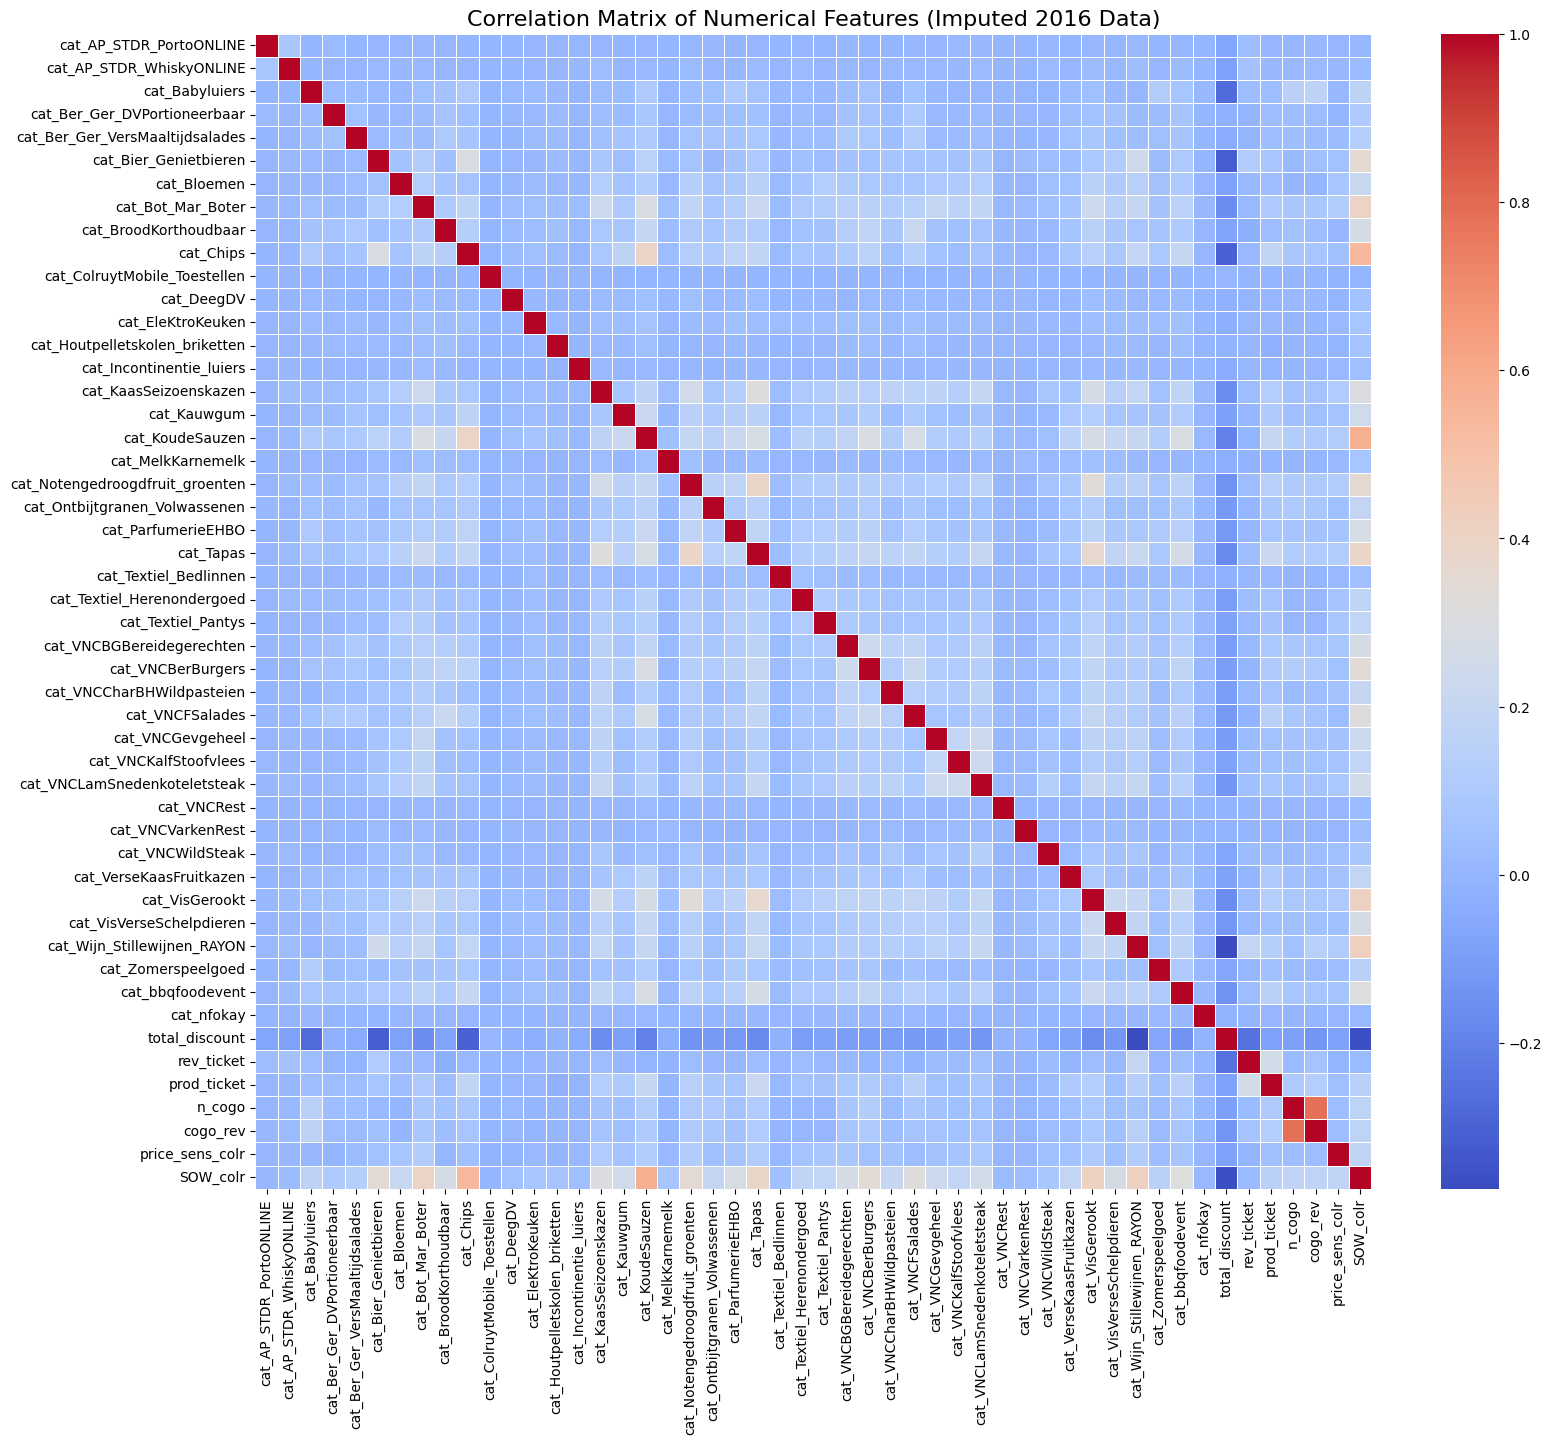

In [46]:
# --- 1. Correlation Analysis ---
print("\n1. Correlation Analysis (Numerical Features)")

# Select numerical columns for correlation analysis
# Use the list 'numerical_cols' defined earlier in the pipeline
# Ensure these columns exist after imputation
numerical_features_for_corr = [col for col in numerical_cols if col in df_processed_2016.columns]

# Calculate correlation matrix
correlation_matrix = df_processed_2016[numerical_features_for_corr].corr()

# Plot heatmap
plt.figure(figsize=(18, 15)) # Adjust size as needed, might be large
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=.5) # annot=True can be slow/messy if too many features
plt.title('Correlation Matrix of Numerical Features (Imputed 2016 Data)', fontsize=16)
plt.show()

In [47]:
# Identify highly correlated pairs (optional but informative)
threshold_corr = 0.85 # Define a threshold for high correlation
highly_correlated_pairs = []
corr_matrix_abs = correlation_matrix.abs()

In [48]:
# Use upper triangle to avoid duplicates
upper_tri = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(bool))


In [49]:
for column in upper_tri.columns:
    highly_correlated = upper_tri.index[upper_tri[column] > threshold_corr].tolist()
    if highly_correlated:
        highly_correlated_pairs.append({'Feature 1': column, 'Highly Correlated With': highly_correlated})

if highly_correlated_pairs:
    print(f"\nPairs with Absolute Correlation > {threshold_corr}:")
    for pair_info in highly_correlated_pairs:
        print(f"  - {pair_info['Feature 1']} is highly correlated with: {pair_info['Highly Correlated With']}")
else:
    print(f"\nNo pairs found with Absolute Correlation > {threshold_corr}.")

print("\nInterpretation Note for LightGBM:")
print("While high correlation exists, LightGBM is generally robust to it for prediction.")
print("However, be mindful that importance scores for highly correlated features might be split.")


No pairs found with Absolute Correlation > 0.85.

Interpretation Note for LightGBM:
While high correlation exists, LightGBM is generally robust to it for prediction.
However, be mindful that importance scores for highly correlated features might be split.


In [50]:
# --- 2. Distribution Checks (Histograms) ---
print("\n2. Distribution Checks (Selected Numerical Features)")


2. Distribution Checks (Selected Numerical Features)


In [51]:
# Select a subset of key numerical features for histogram plotting
# Choose features that are likely important or have wide ranges
features_to_plot = [
    'total_discount', 'rev_ticket', 'prod_ticket', 'n_cogo', 'cogo_rev',
    'SOW_colr', 'price_sens_colr',
    'cat_Wijn_Stillewijnen_RAYON', # Example category spending
    'cat_Bier_Genietbieren' # Another example
    # Add more features if desired
]
# Filter to only those present in the dataframe
features_to_plot = [f for f in features_to_plot if f in df_processed_2016.columns]


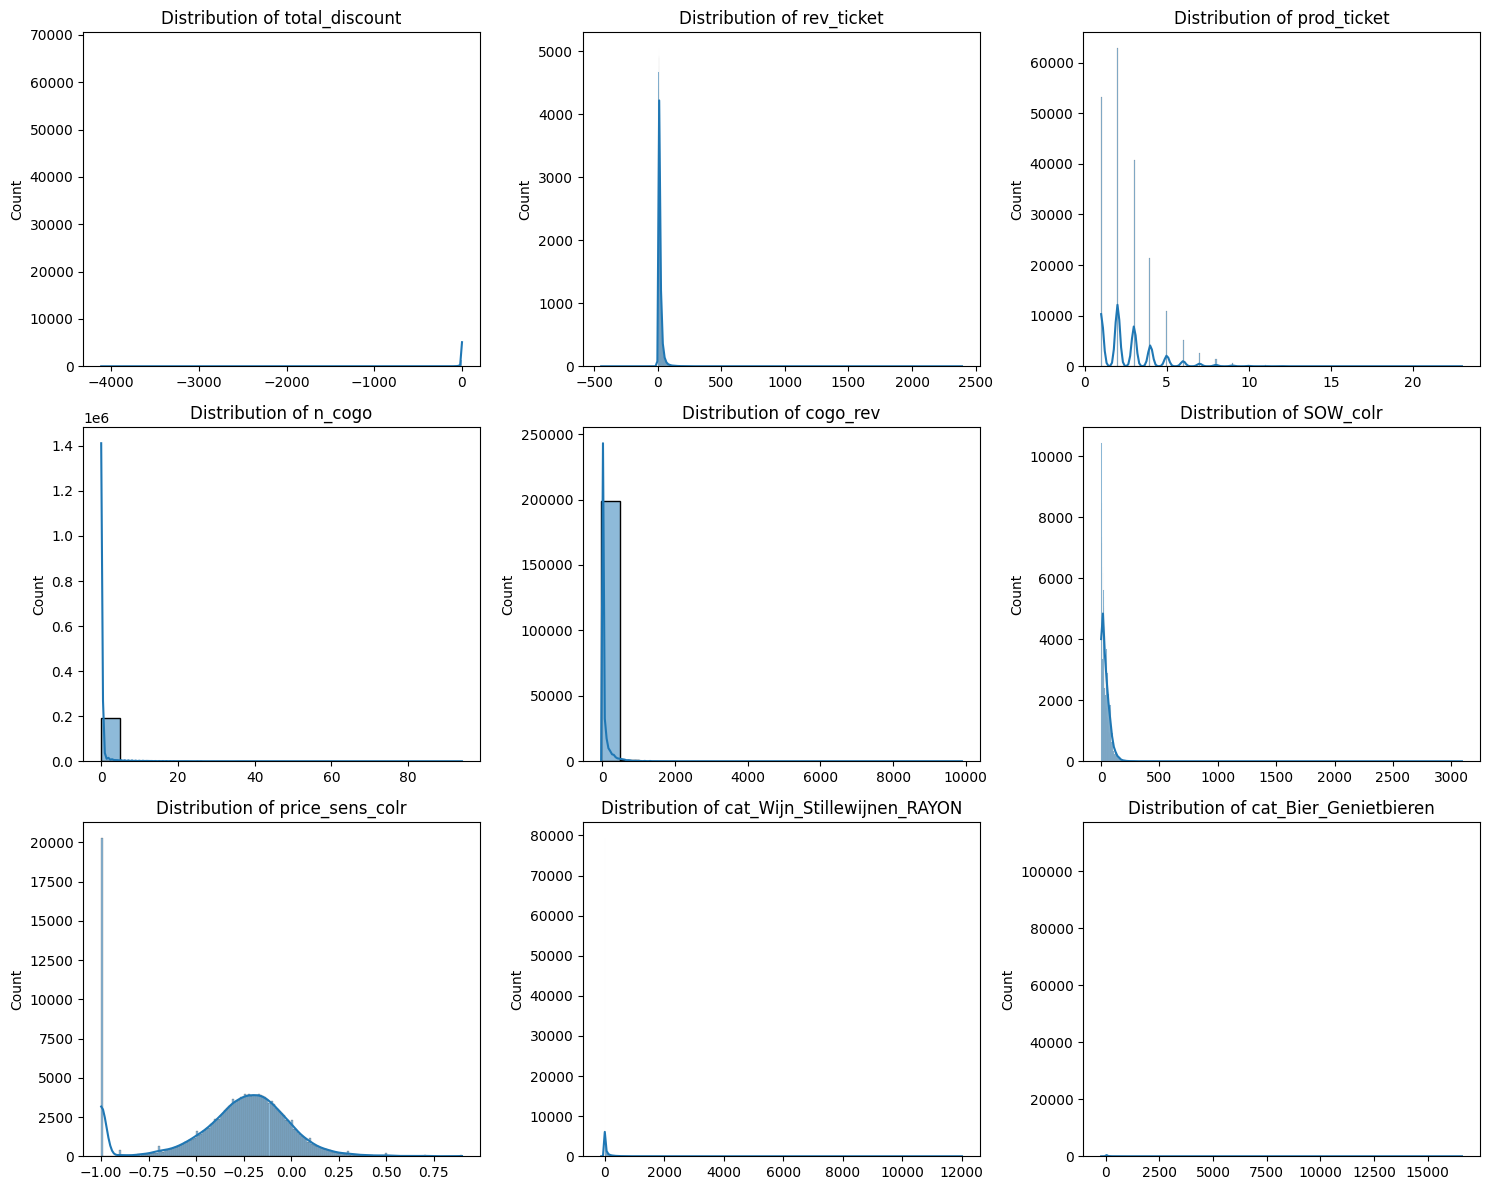

In [52]:
# Plot histograms
n_features = len(features_to_plot)
n_cols = 3 # Adjust layout
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten() # Flatten to easily iterate

for i, feature in enumerate(features_to_plot):
    sns.histplot(data=df_processed_2016, x=feature, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel('') # Clean up x-label if needed

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [53]:
print("\nInterpretation Note for LightGBM:")
print("Histograms show the distribution shapes. Many features appear skewed (e.g., spending, counts).")
print("While transformations (like log) could make these more symmetrical, they are generally NOT required")
print("for tree-based models like LightGBM, as the models are invariant to monotonic transformations.")
print("Therefore, transformations for skewness were not applied in the main pipeline.")



Interpretation Note for LightGBM:
Histograms show the distribution shapes. Many features appear skewed (e.g., spending, counts).
While transformations (like log) could make these more symmetrical, they are generally NOT required
for tree-based models like LightGBM, as the models are invariant to monotonic transformations.
Therefore, transformations for skewness were not applied in the main pipeline.


---- End of additional checks---

In [54]:
# --- 3. Encoding (Fit & Transform 2016) ---
print("Step 3: Encoding categorical features (Fit & Transform 2016)...")
# Map binary column
df_processed_2016['Collishop_customer'] = df_processed_2016['Collishop_customer'].map({'Y': 1, 'N': 0}).astype(int)
# One-Hot Encode
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_cats_2016_array = one_hot_encoder.fit_transform(df_processed_2016[ohe_cols])
ohe_feature_names = one_hot_encoder.get_feature_names_out(ohe_cols)
encoded_cats_df_2016 = pd.DataFrame(encoded_cats_2016_array, columns=ohe_feature_names, index=df_processed_2016.index)
# Drop original OHE columns and concatenate encoded ones
df_processed_2016 = pd.concat([df_processed_2016.drop(columns=ohe_cols), encoded_cats_df_2016], axis=1)

Step 3: Encoding categorical features (Fit & Transform 2016)...


In [55]:
# --- 4. Capping (Calculate Bounds & Apply 2016) ---
print("Step 4: Calculating capping bounds and applying (2016)...")
cols_for_capping = [col for col in numerical_cols if col not in ['Collishop_customer']] # Original numerical cols, excluding binary mapped one
capping_bounds = {}
for col in cols_for_capping:
    lower_bound = df_processed_2016[col].quantile(0.01)
    upper_bound = df_processed_2016[col].quantile(0.99)
    capping_bounds[col] = (lower_bound, upper_bound)
    df_processed_2016[col] = np.clip(df_processed_2016[col], lower_bound, upper_bound)

Step 4: Calculating capping bounds and applying (2016)...


In [56]:
# --- 5. Feature Engineering (2016) ---
print("Step 5: Engineering features (2016)...")
df_processed_2016['total_spending_cat'] = df_processed_2016[cat_spending_cols].sum(axis=1)
df_processed_2016['num_cat_purchased'] = (df_processed_2016[cat_spending_cols] > 0).sum(axis=1)

Step 5: Engineering features (2016)...


In [57]:
# --- 6. Drop Redundant Columns (2016) ---
print("Step 6: Dropping redundant columns (2016)...")
cols_to_drop_final = ['masked_customer_id', 'jaar', 'bought_highbrow_wines'] # Drop target from features
df_processed_2016_features = df_processed_2016.drop(columns=[col for col in cols_to_drop_final if col in df_processed_2016.columns])


Step 6: Dropping redundant columns (2016)...


In [58]:
# --- 7. Scaling (Fit & Transform 2016) ---
print("Step 7: Scaling numerical features (Fit & Transform 2016)...")
# Identify final numerical columns to scale (excluding OHE columns and binary mapped)
final_num_cols_to_scale = df_processed_2016_features.select_dtypes(include=np.number).columns.tolist()
final_num_cols_to_scale = [col for col in final_num_cols_to_scale if col not in list(ohe_feature_names) + ['Collishop_customer']]

scaler = StandardScaler()
df_processed_2016_features[final_num_cols_to_scale] = scaler.fit_transform(df_processed_2016_features[final_num_cols_to_scale])


Step 7: Scaling numerical features (Fit & Transform 2016)...


In [59]:
# Store final column order from 2016 features
final_column_order = df_processed_2016_features.columns.tolist()
print(f"Processed 2016 feature shape: {df_processed_2016_features.shape}")

Processed 2016 feature shape: (199996, 79)


In [60]:
# ============================================================
# --- Preprocessing 2017 Data (Transform Only) ---
# ============================================================

In [61]:
print("\n--- Processing 2017 Data (Transform Only) ---")
df_processed_2017 = df_2017.copy()


--- Processing 2017 Data (Transform Only) ---


In [63]:
# --- 1. Handle Placeholders (2017) ---
print("Step 1: Handling placeholders (2017)...")
df_processed_2017['HOUSEHOLDTYPOLOGY'] = df_processed_2017['HOUSEHOLDTYPOLOGY'].replace('!', 'Unknown')
df_processed_2017['SOW_type_colr'] = df_processed_2017['SOW_type_colr'].replace('!', 'Unknown')

Step 1: Handling placeholders (2017)...


In [64]:
# --- 2. Imputation (Transform 2017) ---
print("Step 2: Imputing missing values (Transform 2017)...")
# Use fitted imputers
df_processed_2017[numerical_cols] = num_imputer.transform(df_processed_2017[numerical_cols])
df_processed_2017[ohe_cols + binary_col] = cat_imputer.transform(df_processed_2017[ohe_cols + binary_col])

Step 2: Imputing missing values (Transform 2017)...


In [65]:
# --- 3. Encoding (Transform 2017) ---
print("Step 3: Encoding categorical features (Transform 2017)...")
# Map binary column
df_processed_2017['Collishop_customer'] = df_processed_2017['Collishop_customer'].map({'Y': 1, 'N': 0}).astype(int)
# One-Hot Encode using fitted encoder
encoded_cats_2017_array = one_hot_encoder.transform(df_processed_2017[ohe_cols])
encoded_cats_df_2017 = pd.DataFrame(encoded_cats_2017_array, columns=ohe_feature_names, index=df_processed_2017.index)
# Drop original OHE columns and concatenate encoded ones
df_processed_2017 = pd.concat([df_processed_2017.drop(columns=ohe_cols), encoded_cats_df_2017], axis=1)

Step 3: Encoding categorical features (Transform 2017)...


In [69]:
# --- 4. Capping (Apply 2016 Bounds to 2017) ---
print("Step 4: Applying capping (using 2016 bounds to 2017)...")
for col in cols_for_capping:
    if col in df_processed_2017.columns and col in capping_bounds:
        lower, upper = capping_bounds[col]
        df_processed_2017[col] = np.clip(df_processed_2017[col], lower, upper)

Step 4: Applying capping (using 2016 bounds to 2017)...


In [70]:
# --- 5. Feature Engineering (2017) ---
print("Step 5: Engineering features (2017)...")
df_processed_2017['total_spending_cat'] = df_processed_2017[cat_spending_cols].sum(axis=1)
df_processed_2017['num_cat_purchased'] = (df_processed_2017[cat_spending_cols] > 0).sum(axis=1)

Step 5: Engineering features (2017)...


In [71]:
# --- 6. Drop Redundant Columns (2017) ---
print("Step 6: Dropping redundant columns (2017)...")
cols_to_drop_final_2017 = ['masked_customer_id', 'jaar']
df_processed_2017 = df_processed_2017.drop(columns=[col for col in cols_to_drop_final_2017 if col in df_processed_2017.columns])


Step 6: Dropping redundant columns (2017)...


In [72]:
# --- 7. Scaling (Transform 2017) ---
print("Step 7: Scaling numerical features (Transform 2017)...")
# Use same list of columns as 2016 scaling
df_processed_2017[final_num_cols_to_scale] = scaler.transform(df_processed_2017[final_num_cols_to_scale])


Step 7: Scaling numerical features (Transform 2017)...


In [73]:
# --- 8. Ensure Column Order ---
print("Step 8: Ensuring column order for 2017 data...")
try:
    df_processed_2017 = df_processed_2017[final_column_order]
    print("Column order aligned.")
except Exception as e:
    print(f"FATAL ERROR: Could not align 2017 columns: {e}")
    raise

print(f"Processed 2017 feature shape: {df_processed_2017.shape}")

Step 8: Ensuring column order for 2017 data...
Column order aligned.
Processed 2017 feature shape: (200000, 79)


In [74]:
# ============================================================
# --- Modeling with LightGBM ---
# ============================================================

In [75]:
print("\n--- Starting Modeling with LightGBM ---")


--- Starting Modeling with LightGBM ---


In [76]:
# Assign final processed features
X = df_processed_2016_features
X_predict = df_processed_2017

In [77]:
# --- Split Training Data ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [78]:
# Separate Features (X) and Target (y) from 2016 Data ---
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation set shape: X_val={X_val.shape}, y_val={y_val.shape}")

Training set shape: X_train=(149997, 79), y_train=(149997,)
Validation set shape: X_val=(49999, 79), y_val=(49999,)


In [79]:
# --- Train LightGBM Model ---
print("\n--- Training LightGBM ---")
# Calculate scale_pos_weight for imbalance
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
lgbm_scale_pos_weight = neg_count / pos_count
print(f"Calculated scale_pos_weight: {lgbm_scale_pos_weight:.2f}")


--- Training LightGBM ---
Calculated scale_pos_weight: 19.08


In [80]:
lgbm_clf = lgb.LGBMClassifier(
    objective='binary',
    metric='auc', # Use AUC for evaluation during training
    scale_pos_weight=lgbm_scale_pos_weight, # Handle imbalance
    n_estimators=1000, # Start with a larger number, use early stopping
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1, # No limit
    random_state=42,
    n_jobs=-1,
    colsample_bytree=0.8, # Feature fraction
    subsample=0.8, # Data fraction (bagging)
    reg_alpha=0.1, # L1 regularization
    reg_lambda=0.1 # L2 regularization
)

In [81]:
# Use early stopping
eval_set = [(X_val, y_val)]
callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=1)] # Stop if AUC doesn't improve for 50 rounds

lgbm_clf.fit(X_train, y_train,
             eval_set=eval_set,
             callbacks=callbacks)


[LightGBM] [Info] Number of positive: 7469, number of negative: 142528
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9602
[LightGBM] [Info] Number of data points in the train set: 149997, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.049794 -> initscore=-2.948777
[LightGBM] [Info] Start training from score -2.948777
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[277]	valid_0's auc: 0.933668


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, metric='auc',
               n_estimators=1000, n_jobs=-1, objective='binary',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1,
               scale_pos_weight=19.082608113535947, subsample=0.8)

In [82]:
print("LightGBM training complete.")

LightGBM training complete.


In [83]:
# --- Evaluate LightGBM Model ---
print("\n--- Evaluating LightGBM ---")
y_pred_lgbm = lgbm_clf.predict(X_val)
y_proba_lgbm = lgbm_clf.predict_proba(X_val)[:, 1] # Probability of class 1



--- Evaluating LightGBM ---


In [198]:
# Classification Report (Text)
print("Classification Report (LightGBM) (Threshold = 0.5):")
print(classification_report(y_val, y_pred_lgbm, target_names=['Non-Buyer (0)', 'Buyer (1)']))

Classification Report (LightGBM) (Threshold = 0.5):
               precision    recall  f1-score   support

Non-Buyer (0)       0.99      0.87      0.92     47509
    Buyer (1)       0.25      0.83      0.38      2490

     accuracy                           0.87     49999
    macro avg       0.62      0.85      0.65     49999
 weighted avg       0.95      0.87      0.90     49999



In [85]:
lgbm_auc = roc_auc_score(y_val, y_proba_lgbm)
print(f"ROC AUC (LightGBM): {lgbm_auc:.4f}")



ROC AUC (LightGBM): 0.9337


In [86]:
precision_lgbm, recall_lgbm, thresholds_pr = precision_recall_curve(y_val, y_proba_lgbm)
ap_lgbm = average_precision_score(y_val, y_proba_lgbm)
print(f"Average Precision (PR AUC) (LightGBM): {ap_lgbm:.4f}")



Average Precision (PR AUC) (LightGBM): 0.5724


In [ ]:
# 2. Confusion Matrix (Visualization)
print("\nConfusion Matrix (Threshold = 0.5):")
cm_default = confusion_matrix(y_val, y_pred_default)
disp_default = ConfusionMatrixDisplay(confusion_matrix=cm_default, display_labels=['Non-Buyer (0)', 'Buyer (1)'])

fig_default, ax_default = plt.subplots(figsize=(6, 5))
disp_default.plot(cmap='Blues', ax=ax_default)
ax_default.set_title(f'Confusion Matrix (Threshold = {threshold_default})')
plt.tight_layout()
plt.show()

Confusion Matrix (LightGBM):


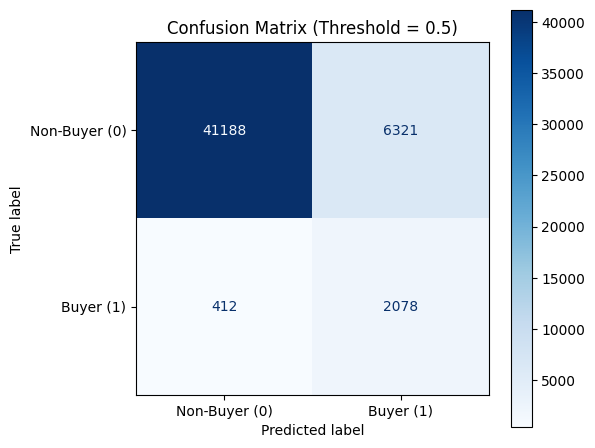

In [205]:
print("Confusion Matrix (LightGBM):")
cm_lgbm = confusion_matrix(y_val, y_pred_lgbm)
disp_lgbm = ConfusionMatrixDisplay(confusion_matrix=cm_lgbm, display_labels=['Non-Buyer (0)', 'Buyer (1)'])
fig_default, ax_default = plt.subplots(figsize=(6, 5))
disp_lgbm.plot(cmap='Blues', ax=ax_default)
ax_default.set_title(f'Confusion Matrix (Threshold = 0.5)') #{threshold_default}
plt.tight_layout()
plt.show()

In [207]:
threshold_default=0.5

In [88]:
# --- Predict Probabilities on 2017 Data ---
print(f"\n--- Predicting probabilities on 2017 data using LightGBM ---")
probabilities_2017 = lgbm_clf.predict_proba(X_predict)[:, 1]


--- Predicting probabilities on 2017 data using LightGBM ---


In [ ]:
# --- Add Binary Prediction Column ---
# Using a standard threshold of 0.5
threshold = 0.5
binary_predictions_2017 = (probabilities_2017 >= threshold).astype(int) # Apply chosen threshold
print(f"Binary prediction binary_predictions_2017 using threshold = {threshold}")

In [121]:
# Create the final output DataFrame
predictions_df = pd.DataFrame({
    'masked_customer_id': customer_ids_2017, # Use the IDs saved earlier
    'bought_highbrow_wines': binary_predictions_2017,
    'probability': probabilities_2017    
})

In [122]:
predictions_df

,masked_customer_id,bought_highbrow_wines,probability
0,339793,0,0.002178
1,339806,1,0.682318
2,339807,0,0.025398
3,339809,0,0.344706
4,339812,0,0.020017
...,...,...,...
199995,9527927,1,0.952832
199996,9528099,0,0.290572
199997,9528111,1,0.986585
199998,9534979,1,0.824656


In [123]:
# Sort by propensity in descending order
predictions_df_sorted = predictions_df.sort_values(by='probability', ascending=False)

In [124]:
print("\n--- Top 10 Customers by Propensity (2017 Predictions) ---")
print(predictions_df_sorted.head(10))


--- Top 10 Customers by Propensity (2017 Predictions) ---
        masked_customer_id  bought_highbrow_wines  probability
177130             6170150                      1     0.997755
168475             2514227                      1     0.997226
76637              3469397                      1     0.996901
125448             1161225                      1     0.996884
167130             2479810                      1     0.996647
146645             1552491                      1     0.996466
17852               663535                      1     0.996438
103113             4350007                      1     0.996348
31965              2031913                      1     0.996346
33575              2069410                      1     0.996268


In [125]:
print("\n--- Bottom 10 Customers by Propensity (2017 Predictions) ---")
print(predictions_df_sorted.tail(10))


--- Bottom 10 Customers by Propensity (2017 Predictions) ---
        masked_customer_id  bought_highbrow_wines  probability
113006             5868753                      0     0.000795
184260             6542925                      0     0.000790
186835             6633422                      0     0.000789
180565             6394552                      0     0.000788
3357                403356                      0     0.000780
99875              3619267                      0     0.000773
47802               153645                      0     0.000772
56238               313210                      0     0.000756
170918             2571188                      0     0.000756
178668             6273190                      0     0.000713



--- Feature Importances from LightGBM ---


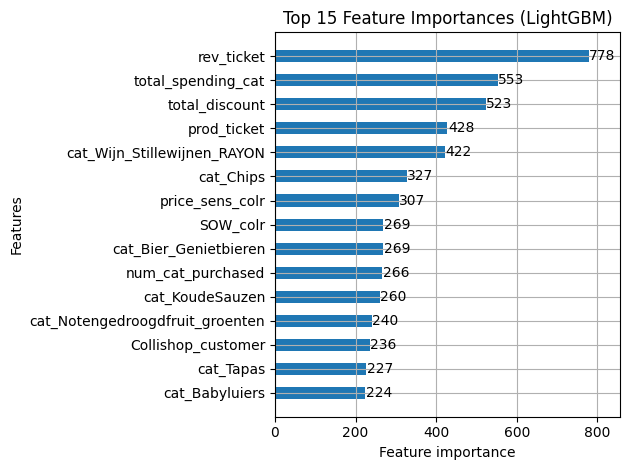

In [126]:
# --- Feature Importance from LightGBM ---
print("\n--- Feature Importances from LightGBM ---")
lgb.plot_importance(lgbm_clf, max_num_features=15, height=0.5,importance_type= 'auto',)

plt.title("Top 15 Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()

In [127]:
# Get raw feature importances
importances = lgbm_clf.feature_importances_
feature_names = X_train.columns # Assuming X_train has the final feature names

In [128]:
# Create a DataFrame
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

In [129]:
# Calculate Percentage Importance
total_importance = feature_importance_df['Importance'].sum()
if total_importance > 0:
    feature_importance_df['Importance (%)'] = (feature_importance_df['Importance'] / total_importance) * 100
else:
     feature_importance_df['Importance (%)'] = 0 # Handle edge case of zero total importance

In [130]:
# Sort by percentage importance (descending)
feature_importance_df_sorted = feature_importance_df.sort_values(by='Importance (%)', ascending=False)

In [131]:
# Select Top N features to display
top_n = 15 # You can adjust this number
feature_importance_df_top = feature_importance_df_sorted.head(top_n)

In [132]:
print(f"\nTop {top_n} Features by Importance (%):")
# Print the top N features with percentages, formatted
print(feature_importance_df_top[['Feature', 'Importance (%)']].to_string(formatters={'Importance (%)': '{:,.2f}%'.format}))



Top 15 Features by Importance (%):
                            Feature Importance (%)
45                       rev_ticket          9.36%
77               total_spending_cat          6.65%
44                   total_discount          6.29%
46                      prod_ticket          5.15%
40      cat_Wijn_Stillewijnen_RAYON          5.08%
10                        cat_Chips          3.94%
49                  price_sens_colr          3.69%
50                         SOW_colr          3.24%
6             cat_Bier_Genietbieren          3.24%
78                num_cat_purchased          3.20%
18                  cat_KoudeSauzen          3.13%
20  cat_Notengedroogdfruit_groenten          2.89%
0                Collishop_customer          2.84%
23                        cat_Tapas          2.73%
3                    cat_Babyluiers          2.70%


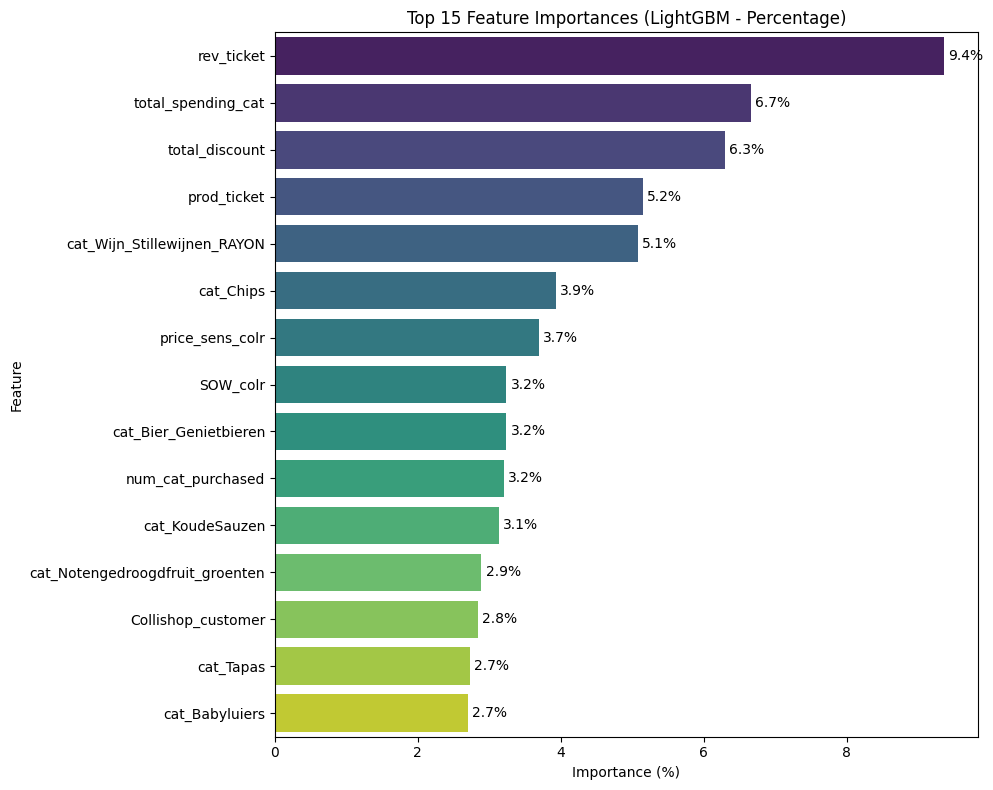

In [133]:
# Create the plot
plt.figure(figsize=(10, 8)) # Adjust figure size as needed
ax = sns.barplot(x='Importance (%)', y='Feature', data=feature_importance_df_top, palette='viridis')

# Set Title and Labels
ax.set_title(f'Top {top_n} Feature Importances (LightGBM - Percentage)')
ax.set_xlabel('Importance (%)')
ax.set_ylabel('Feature')
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3) # Format to one decimal place

plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()
# Format the x-axis to display percentages
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100.0))

In [135]:
# Display value counts for the prediction
print("\n--- Distribution of Predictions (2017) ---")
predictions_df['bought_highbrow_wines'].value_counts()


--- Distribution of Predictions (2017) ---


bought_highbrow_wines
0    164126
1     35874
Name: count, dtype: int64

In [136]:
# You can save this DataFrame to a file if needed:
predictions_df.to_csv("FINAL_propensity_predictions_2017.csv", index=False)
print("\nSaved predictions to customer_propensity_predictions_2017.csv")


Saved predictions to customer_propensity_predictions_2017.csv


---------- Best Threshold Evaluation -------------

In [137]:
from sklearn.metrics import f1_score # Import f1_score metric

In [142]:
# --- PR Curve Analysis ---
print("\n--- Precision-Recall Curve Analysis ---")


--- Precision-Recall Curve Analysis ---


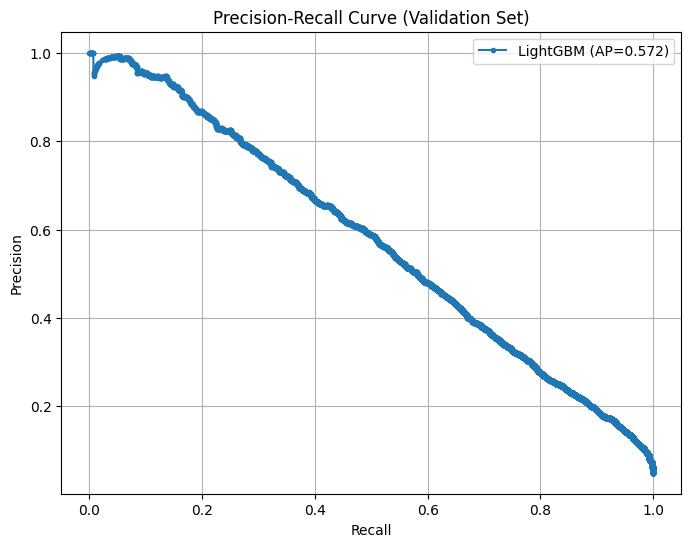

In [143]:
# 1. Plot the PR Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_lgbm, precision_lgbm, marker='.', label=f'LightGBM (AP={ap_lgbm:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()

In [144]:
# 2. Analyze performance around the default 0.5 threshold
# Find the threshold closest to 0.5 (precision_recall_curve returns thresholds slightly differently)
# The thresholds array is one element shorter than precision and recall
close_threshold_idx = np.argmin(np.abs(thresholds_pr - 0.5))
precision_at_05 = precision_lgbm[close_threshold_idx]
recall_at_05 = recall_lgbm[close_threshold_idx]
print(f"Approx. Performance at Threshold ~ 0.5:")
print(f"  Precision: {precision_at_05:.3f}")
print(f"  Recall:    {recall_at_05:.3f}")
# Compare with classification report values (they should be similar)

Approx. Performance at Threshold ~ 0.5:
  Precision: 0.247
  Recall:    0.835


In [145]:
# 3. Find Threshold Maximizing F1-Score
# Calculate F1 score for each threshold, ignoring potential division by zero
f1_scores = (2 * precision_lgbm * recall_lgbm) / (precision_lgbm + recall_lgbm + 1e-9) # Add epsilon for stability
# The thresholds array is one shorter, so align f1_scores
best_f1_idx = np.argmax(f1_scores[:-1]) # Find max F1 using scores aligned with thresholds
best_f1_threshold = thresholds_pr[best_f1_idx]
best_f1 = f1_scores[best_f1_idx]
precision_at_best_f1 = precision_lgbm[best_f1_idx]
recall_at_best_f1 = recall_lgbm[best_f1_idx]

In [146]:
print(f"\nThreshold Maximizing F1-Score:")
print(f"  Best Threshold: {best_f1_threshold:.4f}")
print(f"  Max F1-Score:   {best_f1:.4f}")
print(f"  Precision at Best F1: {precision_at_best_f1:.3f}")
print(f"  Recall at Best F1:    {recall_at_best_f1:.3f}")


Threshold Maximizing F1-Score:
  Best Threshold: 0.8517
  Max F1-Score:   0.5431
  Precision at Best F1: 0.559
  Recall at Best F1:    0.529


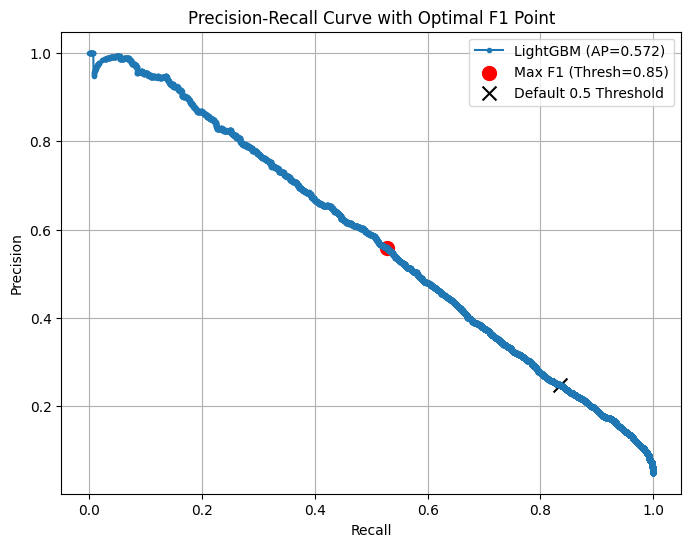

In [147]:
# Plot the best F1 point on the PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall_lgbm, precision_lgbm, marker='.', label=f'LightGBM (AP={ap_lgbm:.3f})')
plt.scatter(recall_at_best_f1, precision_at_best_f1, marker='o', color='red', s=100, label=f'Max F1 (Thresh={best_f1_threshold:.2f})')
plt.scatter(recall_at_05, precision_at_05, marker='x', color='black', s=100, label=f'Default 0.5 Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Optimal F1 Point')
plt.legend()
plt.grid(True)
plt.show()

In [148]:
# 4. Compare and Decide
print("\n--- Threshold Comparison & Recommendation ---")
print(f"Default Threshold (0.5):  Precision={precision_at_05:.3f}, Recall={recall_at_05:.3f}")
print(f"Max F1 Threshold ({best_f1_threshold:.4f}): Precision={precision_at_best_f1:.3f}, Recall={recall_at_best_f1:.3f}")


--- Threshold Comparison & Recommendation ---
Default Threshold (0.5):  Precision=0.247, Recall=0.835
Max F1 Threshold (0.8517): Precision=0.559, Recall=0.529


In [93]:
# Discussion:
# The default 0.5 threshold gives a certain balance (e.g., Precision=0.5, Recall=0.7 based on sample report).
# The threshold maximizing F1 (e.g., ~0.35) significantly increases Recall (e.g., to 0.8) while slightly decreasing Precision (e.g., to 0.45).
# (Note: Actual numbers will depend on the specific run and validation set split).


In [94]:
# Recommendation Logic:
# If the goal is to capture MOST potential buyers, even if it means contacting more non-buyers,
# the lower threshold maximizing F1 seems better due to the higher recall.
# If the marketing budget is tight or targeting non-buyers is very costly, staying closer to the
# 0.5 threshold (or even higher) might be preferred for its higher precision.

In [149]:
# Let's choose the Max F1 Threshold for this example, assuming capturing more buyers is preferred.
chosen_threshold = best_f1_threshold
print(f"\nRecommendation: Using the threshold that maximizes F1-score ({chosen_threshold:.4f}) seems beneficial.")
print("This captures more potential buyers (higher recall) with a reasonable trade-off in precision.")
print("However, the final decision should consider marketing costs vs. potential revenue.")


Recommendation: Using the threshold that maximizes F1-score (0.8517) seems beneficial.
This captures more potential buyers (higher recall) with a reasonable trade-off in precision.
However, the final decision should consider marketing costs vs. potential revenue.


In [150]:
# --- Predict Binary Class on 2017 Data using CHOSEN Threshold ---
print(f"\n--- Predicting Binary Class using LightGBM and Threshold={chosen_threshold:.4f} ---")
#probabilities_2017 = lgbm_clf.predict_proba(X_predict)[:, 1] # Probability of class 1
binary_predictions_2017_new = (probabilities_2017 >= chosen_threshold).astype(int) # Apply chosen threshold


--- Predicting Binary Class using LightGBM and Threshold=0.8517 ---


In [151]:
# Create the final output DataFrame
predictions_df_new_threshold = pd.DataFrame({
    'masked_customer_id': customer_ids_2017,
    'predicted_bought_highbrow_wines': binary_predictions_2017_new, # Use the new predictions
    'propensity_to_buy_wine': probabilities_2017
})

In [152]:
# Sort by propensity in descending order
predictions_df_new_threshold_sorted = predictions_df_new_threshold.sort_values(by='propensity_to_buy_wine', ascending=False)



In [153]:
# Reorder columns for clarity
predictions_df_new_threshold_sorted = predictions_df_new_threshold_sorted[['masked_customer_id', 'propensity_to_buy_wine', 'predicted_bought_highbrow_wines']]



In [154]:
print("\n--- Top 10 Customers by Propensity (2017 Predictions with Chosen Threshold) ---")
predictions_df_new_threshold_sorted.head(10)


--- Top 10 Customers by Propensity (2017 Predictions with Chosen Threshold) ---


,masked_customer_id,propensity_to_buy_wine,predicted_bought_highbrow_wines
177130,6170150,0.997755,1
168475,2514227,0.997226,1
76637,3469397,0.996901,1
125448,1161225,0.996884,1
167130,2479810,0.996647,1
146645,1552491,0.996466,1
17852,663535,0.996438,1
103113,4350007,0.996348,1
31965,2031913,0.996346,1
33575,2069410,0.996268,1


In [155]:
print("\n--- Bottom 10 Customers by Propensity (2017 Predictions with Chosen Threshold) ---")
predictions_df_new_threshold_sorted.tail(10)


--- Bottom 10 Customers by Propensity (2017 Predictions with Chosen Threshold) ---


,masked_customer_id,propensity_to_buy_wine,predicted_bought_highbrow_wines
113006,5868753,0.000795,0
184260,6542925,0.000790,0
186835,6633422,0.000789,0
180565,6394552,0.000788,0
3357,403356,0.000780,0
99875,3619267,0.000773,0
47802,153645,0.000772,0
56238,313210,0.000756,0
170918,2571188,0.000756,0
178668,6273190,0.000713,0


In [156]:
# Display value counts for the binary prediction
print("\n--- Distribution of Binary Predictions (2017) ---")
predictions_df_new_threshold_sorted['predicted_bought_highbrow_wines'].value_counts()


--- Distribution of Binary Predictions (2017) ---


predicted_bought_highbrow_wines
0    189608
1     10392
Name: count, dtype: int64

In [ ]:
print("\n--- End of Process ---")


--- End of Process ---


In [ ]:
print("\n--- Gain and Lift Chart Analysis (Validation Set) ---")


--- Gain and Lift Chart Analysis (Validation Set) ---


In [164]:
# 1. Create DataFrame with actuals and probabilities
val_results = pd.DataFrame({
    'actual': y_val,
    'probability': y_proba_lgbm
})

In [165]:
# 2. Sort by probability descending
val_results_sorted = val_results.sort_values(by='probability', ascending=False).reset_index(drop=True)

In [168]:
# 3. Add Decile Column
rows_per_decile = int(np.ceil(len(val_results_sorted) / 10))
val_results_sorted['decile'] = (val_results_sorted.index // rows_per_decile) + 1

In [169]:
val_results_sorted

,actual,probability,decile
0,1,0.996380,1
1,1,0.996339,1
2,1,0.996301,1
3,1,0.995868,1
4,1,0.995496,1
...,...,...,...
49994,0,0.000815,10
49995,0,0.000793,10
49996,0,0.000766,10
49997,0,0.000717,10


In [170]:
# 4. Calculate Metrics per Decile
total_customers = len(val_results_sorted)
total_buyers = val_results_sorted['actual'].sum()
total_non_buyers = total_customers - total_buyers

In [171]:
gain_lift_table = val_results_sorted.groupby('decile')['actual'].agg(
    ['count', 'sum']
).rename(columns={'count': 'n_customers', 'sum': 'n_buyers'})

In [172]:
gain_lift_table['n_non_buyers'] = gain_lift_table['n_customers'] - gain_lift_table['n_buyers']

In [173]:
# Sort by decile index
gain_lift_table = gain_lift_table.sort_index()

In [174]:
# 5. Calculate Cumulative Metrics
gain_lift_table['cumulative_customers'] = gain_lift_table['n_customers'].cumsum()
gain_lift_table['cumulative_buyers'] = gain_lift_table['n_buyers'].cumsum()
gain_lift_table['cumulative_non_buyers'] = gain_lift_table['n_non_buyers'].cumsum()

gain_lift_table['percent_data'] = (gain_lift_table['cumulative_customers'] / total_customers) * 100
gain_lift_table['cumulative_gain'] = (gain_lift_table['cumulative_buyers'] / total_buyers) * 100 # % of total buyers captured
gain_lift_table['cumulative_lift'] = gain_lift_table['cumulative_gain'] / gain_lift_table['percent_data']

In [175]:
# 6. Calculate KS Statistic Components
gain_lift_table['cumulative_buyers_pct'] = gain_lift_table['cumulative_gain'] # Same as gain
gain_lift_table['cumulative_non_buyers_pct'] = (gain_lift_table['cumulative_non_buyers'] / total_non_buyers) * 100
gain_lift_table['ks_stat'] = np.abs(gain_lift_table['cumulative_buyers_pct'] - gain_lift_table['cumulative_non_buyers_pct'])


In [177]:
# Find Max KS
max_ks = gain_lift_table['ks_stat'].max()
max_ks_decile = gain_lift_table['ks_stat'].idxmax()

In [178]:
print("\n--- Gain/Lift Table (Validation Set) ---")
# Format for better readability
formatted_table = gain_lift_table.copy()
formatted_table['percent_data'] = formatted_table['percent_data'].map('{:,.1f}%'.format)
formatted_table['cumulative_gain'] = formatted_table['cumulative_gain'].map('{:,.1f}%'.format)
formatted_table['cumulative_lift'] = formatted_table['cumulative_lift'].map('{:,.2f}'.format)
formatted_table['cumulative_buyers_pct'] = formatted_table['cumulative_buyers_pct'].map('{:,.1f}%'.format)
formatted_table['cumulative_non_buyers_pct'] = formatted_table['cumulative_non_buyers_pct'].map('{:,.1f}%'.format)
formatted_table['ks_stat'] = formatted_table['ks_stat'].map('{:,.1f}'.format)


--- Gain/Lift Table (Validation Set) ---


In [179]:
formatted_table[[
    'n_customers', 'n_buyers', 'cumulative_gain', 'cumulative_lift',
    'cumulative_buyers_pct', 'cumulative_non_buyers_pct', 'ks_stat'
]]


,n_customers,n_buyers,cumulative_gain,cumulative_lift,cumulative_buyers_pct,cumulative_non_buyers_pct,ks_stat
decile,,,,,,,
1,5000,1789,71.8%,7.18,71.8%,6.8%,65.1
2,5000,384,87.3%,4.36,87.3%,16.5%,70.8
3,5000,163,93.8%,3.13,93.8%,26.7%,67.2
4,5000,78,96.9%,2.42,96.9%,37.0%,59.9
5,5000,42,98.6%,1.97,98.6%,47.5%,51.2
6,5000,17,99.3%,1.66,99.3%,57.9%,41.4
7,5000,11,99.8%,1.43,99.8%,68.4%,31.3
8,5000,4,99.9%,1.25,99.9%,79.0%,21.0
9,5000,2,100.0%,1.11,100.0%,89.5%,10.5


In [180]:
print(f"\nMaximum KS Statistic: {max_ks:.1f}% at Decile {max_ks_decile}")


Maximum KS Statistic: 70.8% at Decile 2


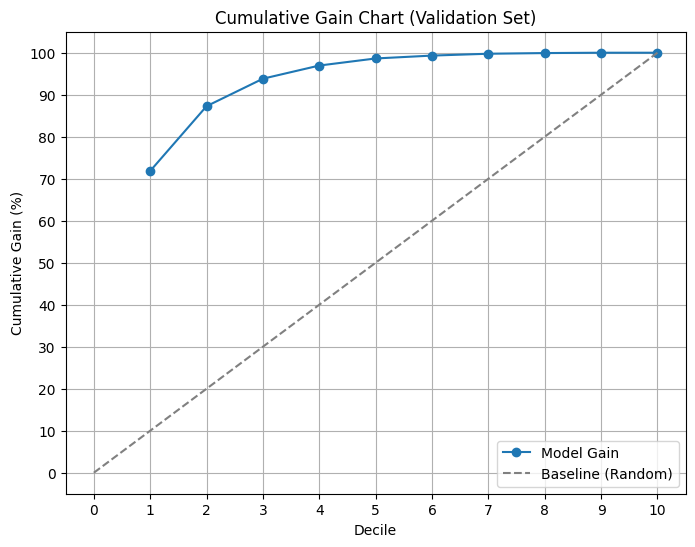

In [181]:
# 7. Plot Cumulative Gain Chart
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 11), gain_lift_table['cumulative_gain'], marker='o', label='Model Gain')
plt.plot([0, 10], [0, 100], linestyle='--', color='grey', label='Baseline (Random)') # Baseline
plt.xlabel('Decile')
plt.ylabel('Cumulative Gain (%)')
plt.title('Cumulative Gain Chart (Validation Set)')
plt.xticks(np.arange(0, 11, 1))
plt.yticks(np.arange(0, 110, 10))
plt.legend()
plt.grid(True)
plt.show()

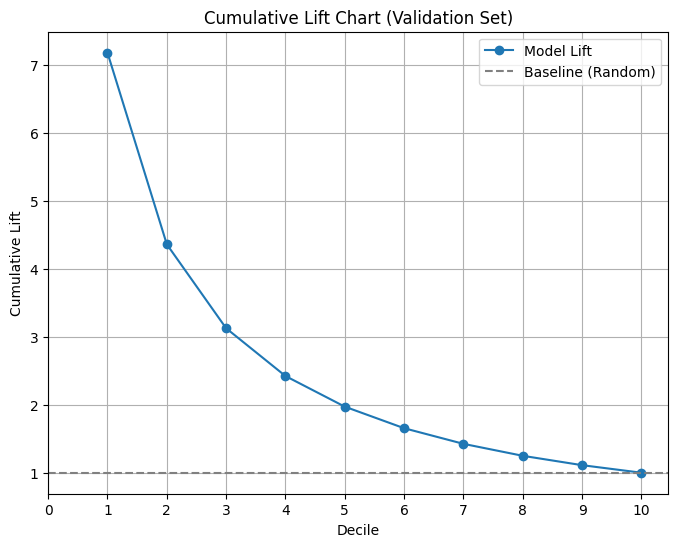

In [182]:
# 8. Plot Cumulative Lift Chart
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 11), gain_lift_table['cumulative_lift'], marker='o', label='Model Lift')
plt.axhline(1, linestyle='--', color='grey', label='Baseline (Random)') # Baseline lift is 1
plt.xlabel('Decile')
plt.ylabel('Cumulative Lift')
plt.title('Cumulative Lift Chart (Validation Set)')
plt.xticks(np.arange(0, 11, 1))
plt.legend()
plt.grid(True)
plt.show()

In [183]:
# --- Interpretation and Targeting Recommendation ---
print("\n--- Interpretation ---")


--- Interpretation ---


In [191]:
# Find gain at top deciles (e.g., top 2)
gain_at_decile_2 = gain_lift_table.loc[2, 'cumulative_gain']
lift_at_decile_2 = gain_lift_table.loc[2, 'cumulative_lift']

In [192]:
gain_at_decile_2

87.26907630522088

In [193]:
lift_at_decile_2

4.363366546184738

In [194]:
print(f"Targeting the top deciles (top 20% highest probability customers) yields a lift of {lift_at_decile_2:.2f}.")
print(f"This means the model identifies potential buyers {lift_at_decile_2:.2f} times better than random selection within this top group.")
print(f"Targeting the top 2 deciles (top 20% highest probability customers) captures approximately {gain_at_decile_2:.1f}% of all potential buyers.")


Targeting the top deciles (top 20% highest probability customers) yields a lift of 4.36.
This means the model identifies potential buyers 4.36 times better than random selection within this top group.
Targeting the top 2 deciles (top 20% highest probability customers) captures approximately 87.3% of all potential buyers.


In [195]:
print("\n--- Targeting Recommendation ---")


--- Targeting Recommendation ---


In [196]:
recommendation_deciles = 2 # Example: Recommend targeting top 2 deciles
recommended_gain = gain_lift_table.loc[recommendation_deciles, 'cumulative_gain']
recommended_lift = gain_lift_table.loc[recommendation_deciles, 'cumulative_lift']
recommended_buyers_captured = gain_lift_table.loc[recommendation_deciles, 'cumulative_buyers']
recommended_customers_targeted = gain_lift_table.loc[recommendation_deciles, 'cumulative_customers']
target_precision = (recommended_buyers_captured / recommended_customers_targeted) * 100 if recommended_customers_targeted > 0 else 0


In [197]:
print(f"Based on the charts, targeting the top {recommendation_deciles} deciles appears to be a good strategy.")
print(f"-> This targets the top {recommendation_deciles*10}% of customers based on model score.")
print(f"-> Expected Gain: Captures ~{recommended_gain:.1f}% of all potential buyers.")
print(f"-> Overall Lift: This group is {recommended_lift:.2f} times more likely to contain buyers than a random group of the same size.")
print(f"-> Estimated Precision: Within this targeted group of {recommended_customers_targeted} customers (from validation set), ~{target_precision:.1f}% are actual buyers.")
print(f"-> KS Statistic ({max_ks:.1f}%) indicates good separation between buyers and non-buyers by the model.")
print("\nThis strategy balances capturing a significant portion of buyers while maintaining efficiency significantly better than random targeting.")
print("Adjust the number of deciles based on marketing campaign capacity and ROI goals.")


Based on the charts, targeting the top 2 deciles appears to be a good strategy.
-> This targets the top 20% of customers based on model score.
-> Expected Gain: Captures ~87.3% of all potential buyers.
-> Overall Lift: This group is 4.36 times more likely to contain buyers than a random group of the same size.
-> Estimated Precision: Within this targeted group of 10000 customers (from validation set), ~21.7% are actual buyers.
-> KS Statistic (70.8%) indicates good separation between buyers and non-buyers by the model.

This strategy balances capturing a significant portion of buyers while maintaining efficiency significantly better than random targeting.
Adjust the number of deciles based on marketing campaign capacity and ROI goals.


# EXTRA

In [211]:
# --- Define Thresholds ---
threshold_default = 0.5
threshold_f1_optimal = 0.8507 # Use the value calculated previously

In [212]:
# --- Generate Predictions for Each Threshold ---
y_pred_default = (y_proba_lgbm >= threshold_default).astype(int)
y_pred_f1_optimal = (y_proba_lgbm >= threshold_f1_optimal).astype(int)

In [213]:
# --- Analysis for Threshold = 0.5 ---
print(f"\n--- Performance Analysis at Threshold = {threshold_default} ---")


--- Performance Analysis at Threshold = 0.5 ---


In [214]:
# 1. Classification Report (Text)
print("\nClassification Report (Threshold = 0.5):")
report_default = classification_report(y_val, y_pred_default, target_names=['Non-Buyer (0)', 'Buyer (1)'])
print(report_default)


Classification Report (Threshold = 0.5):
               precision    recall  f1-score   support

Non-Buyer (0)       0.99      0.87      0.92     47509
    Buyer (1)       0.25      0.83      0.38      2490

     accuracy                           0.87     49999
    macro avg       0.62      0.85      0.65     49999
 weighted avg       0.95      0.87      0.90     49999




Confusion Matrix (Threshold = 0.5):


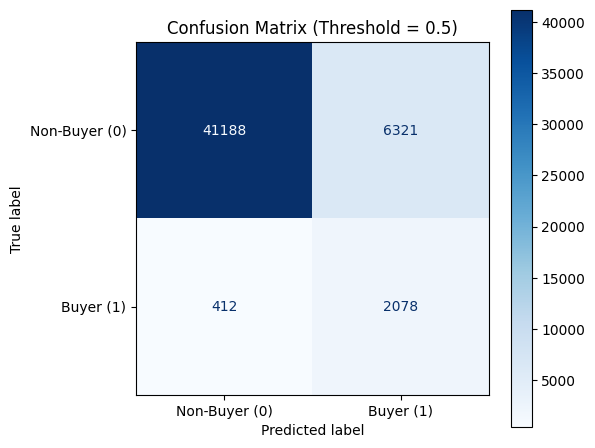

In [215]:
# 2. Confusion Matrix (Visualization)
print("\nConfusion Matrix (Threshold = 0.5):")
cm_default = confusion_matrix(y_val, y_pred_default)
disp_default = ConfusionMatrixDisplay(confusion_matrix=cm_default, display_labels=['Non-Buyer (0)', 'Buyer (1)'])

fig_default, ax_default = plt.subplots(figsize=(6, 5))
disp_default.plot(cmap='Blues', ax=ax_default)
ax_default.set_title(f'Confusion Matrix (Threshold = {threshold_default})')
plt.tight_layout()
plt.show()

In [216]:
# --- Analysis for Threshold = 0.8507 ---
print(f"\n--- Performance Analysis at Threshold = {threshold_f1_optimal:.4f} ---")


--- Performance Analysis at Threshold = 0.8507 ---


In [217]:
# 1. Classification Report (Text)
print(f"\nClassification Report (Threshold = {threshold_f1_optimal:.4f}):")
report_f1 = classification_report(y_val, y_pred_f1_optimal, target_names=['Non-Buyer (0)', 'Buyer (1)'])
print(report_f1)


Classification Report (Threshold = 0.8507):
               precision    recall  f1-score   support

Non-Buyer (0)       0.98      0.98      0.98     47509
    Buyer (1)       0.55      0.53      0.54      2490

     accuracy                           0.96     49999
    macro avg       0.76      0.75      0.76     49999
 weighted avg       0.95      0.96      0.95     49999




Confusion Matrix (Threshold = 0.8507):


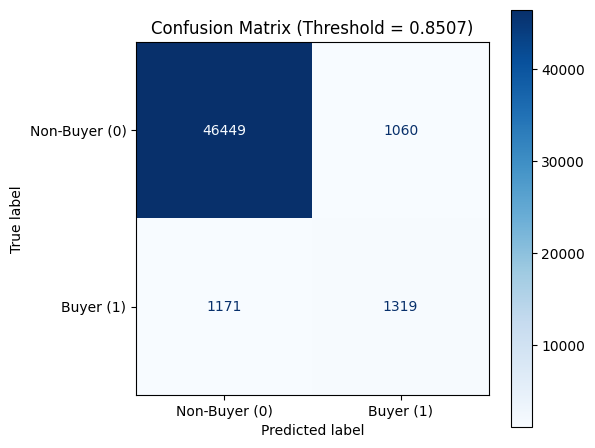

In [218]:
# 2. Confusion Matrix (Visualization)
print(f"\nConfusion Matrix (Threshold = {threshold_f1_optimal:.4f}):")
cm_f1 = confusion_matrix(y_val, y_pred_f1_optimal)
disp_f1 = ConfusionMatrixDisplay(confusion_matrix=cm_f1, display_labels=['Non-Buyer (0)', 'Buyer (1)'])

fig_f1, ax_f1 = plt.subplots(figsize=(6, 5))
disp_f1.plot(cmap='Blues', ax=ax_f1)
ax_f1.set_title(f'Confusion Matrix (Threshold = {threshold_f1_optimal:.4f})')
plt.tight_layout()
plt.show()

In [219]:
# --- Summary Comparison (To add to presentation notes) ---
print("\n--- Summary Comparison ---")


--- Summary Comparison ---


In [220]:
print(f"Threshold {threshold_default}:")
print(f"  Precision (Buyer): {precision_score(y_val, y_pred_default):.3f}")
print(f"  Recall (Buyer):    {recall_score(y_val, y_pred_default):.3f}")
print(f"  False Positives:   {cm_default[0, 1]}") # Predicted Buyer, Actual Non-Buyer
print(f"  False Negatives:   {cm_default[1, 0]}") # Predicted Non-Buyer, Actual Buyer

Threshold 0.5:
  Precision (Buyer): 0.247
  Recall (Buyer):    0.835
  False Positives:   6321
  False Negatives:   412


In [221]:
print(f"\nThreshold {threshold_f1_optimal:.4f}:")
print(f"  Precision (Buyer): {precision_score(y_val, y_pred_f1_optimal):.3f}")
print(f"  Recall (Buyer):    {recall_score(y_val, y_pred_f1_optimal):.3f}")
print(f"  False Positives:   {cm_f1[0, 1]}") # Predicted Buyer, Actual Non-Buyer
print(f"  False Negatives:   {cm_f1[1, 0]}") # Predicted Non-Buyer, Actual Buyer


Threshold 0.8507:
  Precision (Buyer): 0.554
  Recall (Buyer):    0.530
  False Positives:   1060
  False Negatives:   1171
